# Install pytorch
- https://pytorch.org/

1. Go to anaconda terminal as admin and enter
```bash
conda create --name pytorch_cpu python=3.12
```

2. activate environment

```bash
conda activate pytorch_cpu
```

3. install pytorch
```bash 

# CPU Only Windows and Linux
conda install pytorch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 cpuonly -c pytorch

# MAC OSX
conda install pytorch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 -c pytorch

```

4. install additional packages from dslabs and data functions
```bash
conda install pandas scikit-learn matplotlib statsmodels
```

5. if jupyter has errors run

```bash
conda install -n pytorch_cpu ipykernel --update-deps --force-reinstall
```



# DSLabs functions

In [1]:
%run "scripts/dslabs_functions.py"


# Data functions

In [2]:
%run "scripts/data_functions.py"


data_functions loaded


# Load

In [3]:
import pandas as pd
import numpy as np

train=pd.read_csv(f"dataset/series_scaled_agg_w_train.csv", index_col='date', parse_dates=True,  infer_datetime_format=True)
test=pd.read_csv(f"dataset/series_scaled_agg_w_test.csv", index_col='date', parse_dates=True,  infer_datetime_format=True)

target='sales'
file_tag = "Ecuadorian Store Sales"

#trnX = train.drop(columns=[target])
#trnY = train[target]
#tstX = test.drop(columns=[target])
#tstY = test[target]

test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49 entries, 2016-09-12 to 2017-08-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   49 non-null     float64
dtypes: float64(1)
memory usage: 784.0 bytes


In [17]:
test.head()

,sales
date,
2016-09-12,0.009946
2016-09-19,0.016876
2016-09-26,0.131549
2016-10-03,0.099607
2016-10-10,0.031816


In [4]:
# # unsmoothed time series with split to test the model. uncomment to use
# test_split_threshold = 0.7
# data_no_smoothing=pd.read_csv('data/df_merch_0_2024_agg_time_diff_input.csv', decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)     
# train, test = series_train_test_split(data_no_smoothing, trn_pct=test_split_threshold)

# LSTM Pytorch Univariate

## Univariate Pytorch Functions and data prep

In [5]:
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset


def prepare_dataset_for_lstm_uni(series, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(series) - seq_length):
        past = series[i : i + seq_length]
        future = series[i + 1 : i + seq_length + 1]
        setX.append(past)
        setY.append(future)
    return tensor(setX), tensor(setY)


class DS_LSTM_Univariate(Module):
    def __init__(self, train, input_size: int = 1, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm_uni(train, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(train) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred[:, -1, :]

In [6]:
from dslabs_functions import HEIGHT, plot_multiline_chart
from copy import deepcopy

from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


def lstm_study_uni(train, test, nr_episodes: int = 1000, sequence_size: list =[2,4,8], nr_hidden_units: list =[25,50,100], measure: str = "R2"):
    # sequence_size = [2, 4, 8]
    # nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm_uni(test, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM_Univariate(train, hidden_size=hidden)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval: float = FORECAST_MEASURES[measure](test[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params["params"][0]} hidden_units={best_params["params"][1]} and nr_episodes={best_params["params"][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params


## Univariate Pytorch Study

seq length=1 hidden_units=5 nr_episodes=0 -14.08267879486084
seq length=1 hidden_units=5 nr_episodes=2 -10.726882934570312
seq length=1 hidden_units=5 nr_episodes=4 -7.935630798339844
seq length=1 hidden_units=5 nr_episodes=6 -5.608209133148193
seq length=1 hidden_units=5 nr_episodes=8 -3.7236008644104004
seq length=1 hidden_units=5 nr_episodes=10 -2.2758350372314453
seq length=1 hidden_units=5 nr_episodes=12 -1.2876214981079102
seq length=1 hidden_units=5 nr_episodes=14 -0.6936397552490234
seq length=1 hidden_units=5 nr_episodes=16 -0.38109123706817627
seq length=1 hidden_units=5 nr_episodes=18 -0.23306477069854736
seq length=1 hidden_units=5 nr_episodes=20 -0.15493786334991455
seq length=1 hidden_units=15 nr_episodes=0 -6.300178050994873
seq length=1 hidden_units=15 nr_episodes=2 -4.159494400024414
seq length=1 hidden_units=15 nr_episodes=4 -4.012892246246338
seq length=1 hidden_units=15 nr_episodes=6 -4.014526844024658
seq length=1 hidden_units=15 nr_episodes=8 -3.71049165725708
seq

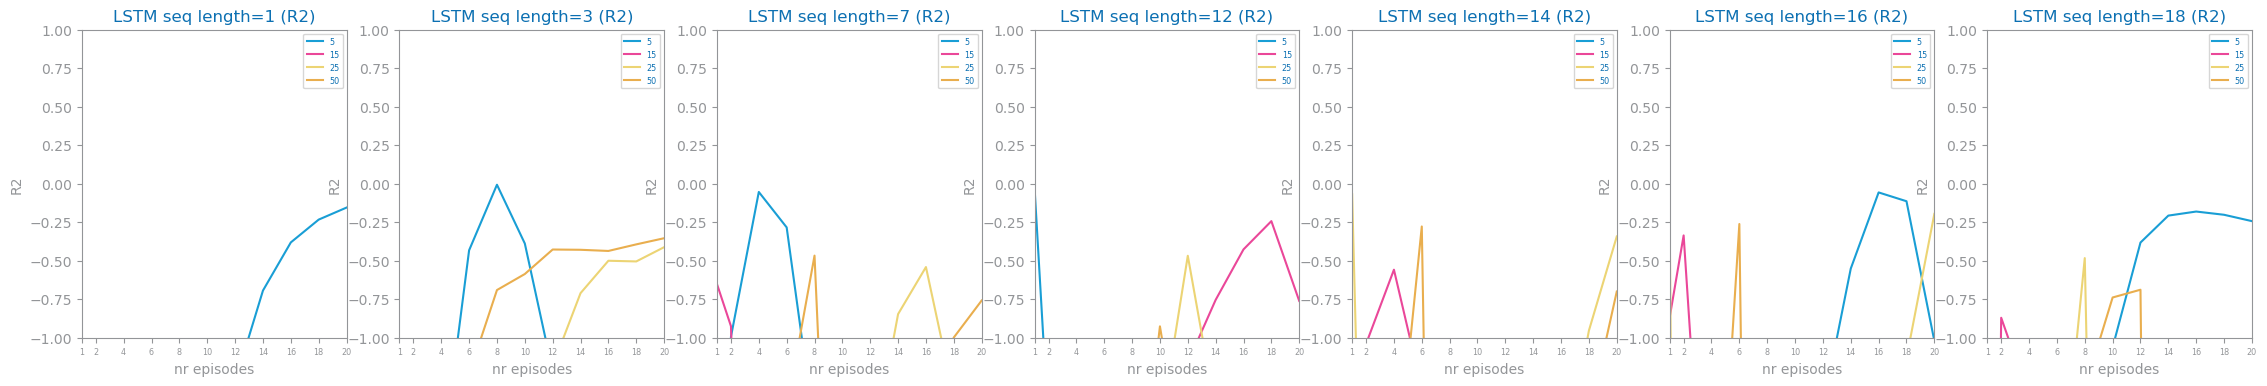

In [7]:
# # Prepare the training and testing data using the time index as the feature
from numpy import arange


train_series_float = train[[target]].values.astype("float32")
test_series_float = test[[target]].values.astype("float32")


best_model, best_params = lstm_study_uni(train_series_float, test_series_float, nr_episodes=20,sequence_size=[1,3,7,12,14,16,18],nr_hidden_units=[5,15,25,50], measure='R2')

## Univariate Pytorch eval

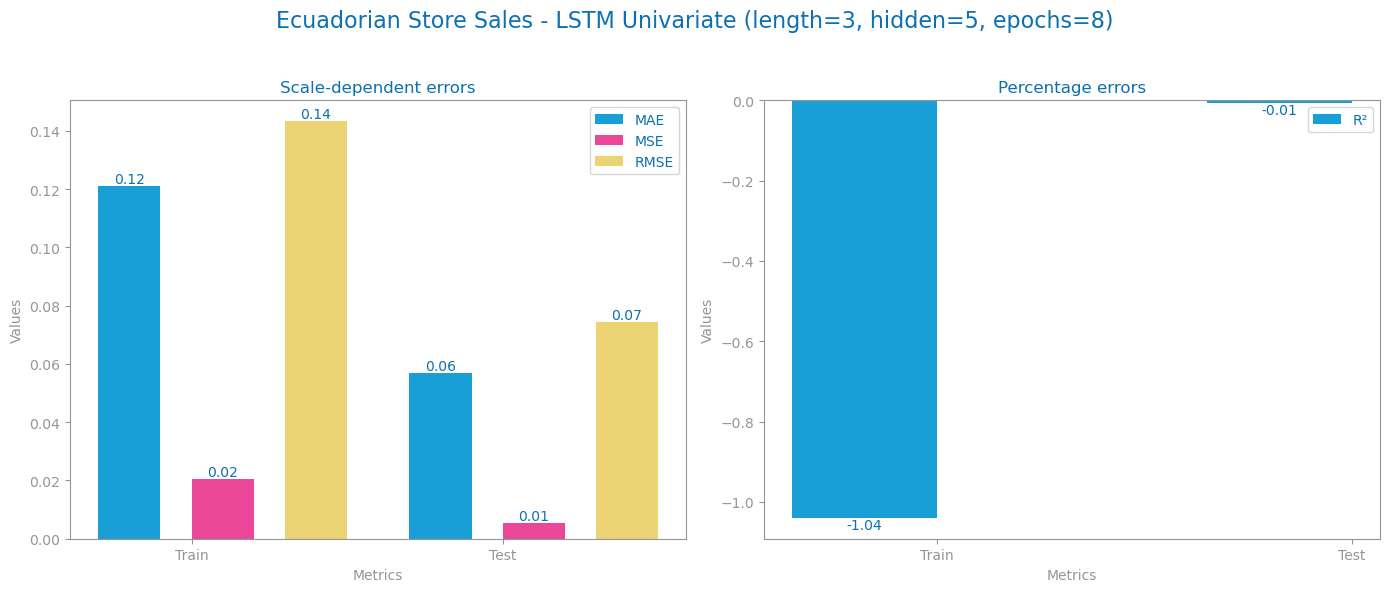

In [8]:
params = best_params["params"]
best_length = params[0]

# Assuming train and test are DataFrames with a DateTime index
trn_series = train[[target]]
tst_series = test[[target]]

trnX, trnY = prepare_dataset_for_lstm_uni(trn_series.values.astype("float32"), seq_length=best_length)
tstX, tstY  = prepare_dataset_for_lstm_uni(tst_series.values.astype("float32"), seq_length=best_length)

prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

# Plot the forecasting evaluation
plot_single_model_evaluation(trn_series[best_length:], tst_series[best_length:], prd_trn, prd_tst, title=f"{file_tag} - LSTM Univariate (length={best_length}, hidden={params[1]}, epochs={params[2]})")


## Plot lstm tensorflow model univariate

<Axes: xlabel='Date', ylabel='sales'>

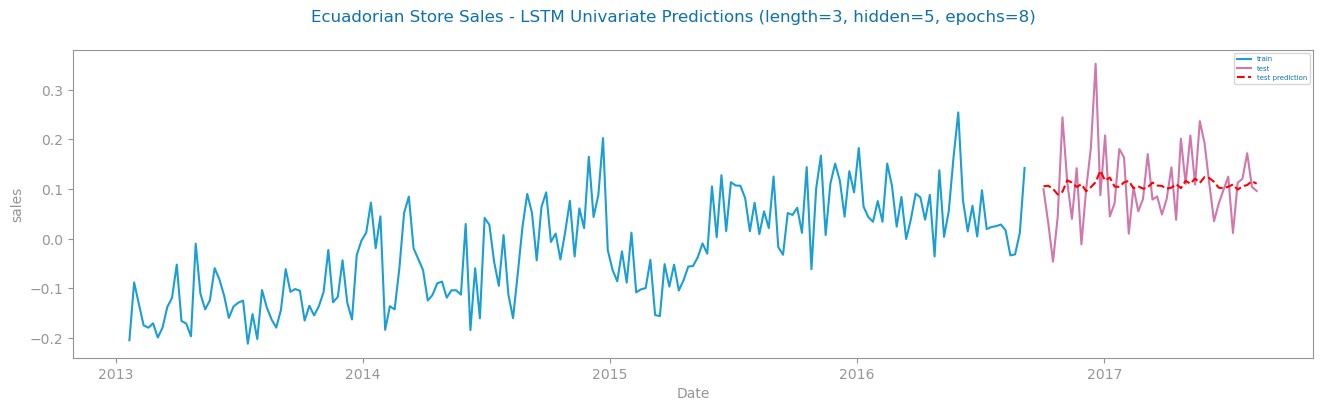

In [9]:
from pandas import Series
pred_series = Series(prd_tst.numpy().ravel(), index=tst_series.index[best_length:])


plot_forecasting_series(
    trn_series[best_length:],
    tst_series[best_length:],
    pred_series,
    title=f"{file_tag} - LSTM Univariate Predictions (length={best_length}, hidden={params[1]}, epochs={params[2]})",
    xlabel='Date',
    ylabel=target,
)

## Pytorch Univariate Model and Loss

In [10]:
model = DS_LSTM_Univariate(train_series_float, input_size=train_series_float.shape[1], hidden_size=50, num_layers=1)
loss = model.fit()
print(loss)

tensor(0.0109, grad_fn=<MseLossBackward0>)


# LSTM Pytorch Multivariate

In [22]:
import pandas as pd
import numpy as np

train=pd.read_csv(f"dataset/series_scaled_agg_w_train_multi.csv", index_col='date', parse_dates=True,  infer_datetime_format=True)
test=pd.read_csv(f"dataset/series_scaled_agg_w_test_multi.csv", index_col='date', parse_dates=True,  infer_datetime_format=True)

target='sales'
file_tag = "Ecuadorian Store Sales"

#trnX = train.drop(columns=[target])
#trnY = train[target]
#tstX = test.drop(columns=[target])
#tstY = test[target]

test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49 entries, 2016-09-12 to 2017-08-14
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sales        49 non-null     float64
 1   onpromotion  49 non-null     float64
dtypes: float64(2)
memory usage: 1.1 KB


## Pytorch Multivariate Functions

In [23]:
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

def prepare_dataset_for_lstm_multi(features, target, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(target) - seq_length):
        past = features[i : i + seq_length]
        future = target[i + seq_length]  # Predict the next value only
        setX.append(past)
        setY.append(future)
    setX = tensor(np.array(setX, dtype=np.float32))  # Convert to torch.float32
    setY = tensor(np.array(setY, dtype=np.float32)).view(-1, 1)  # Convert to torch.float32 and reshape
    return setX, setY


class DS_LSTM_Multivariate(Module):
    def __init__(self, trainX, trainY, input_size: int, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm_multi(trainX, trainY, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(trainX) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])  # Use the last output of the LSTM
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred

from dslabs_functions import HEIGHT, plot_multiline_chart
from copy import deepcopy
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart

def lstm_study_multi(trainX, trainY, testX, testY, nr_episodes: int = 1000,sequence_size: list =[2,4,8], nr_hidden_units: list =[25,50,100], measure: str = "R2"):
    # sequence_size = [2, 4, 8]
    # nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm_multi(testX, testY, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM_Multivariate(trainX, trainY, input_size=trainX.shape[1], hidden_size=hidden, length=length)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval: float = FORECAST_MEASURES[measure](testY[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params['params'][0]} hidden_units={best_params['params'][1]} and nr_episodes={best_params['params'][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params


## Pytorch Multivariate Data Study

seq length=1 hidden_units=5 nr_episodes=0 0.05129724740982056
seq length=1 hidden_units=5 nr_episodes=2 -0.21478772163391113
seq length=1 hidden_units=5 nr_episodes=4 -0.14549672603607178
seq length=1 hidden_units=5 nr_episodes=6 -0.0030962228775024414
seq length=1 hidden_units=5 nr_episodes=8 -0.06690573692321777
seq length=1 hidden_units=5 nr_episodes=10 -0.15774166584014893
seq length=1 hidden_units=5 nr_episodes=12 -0.28748512268066406
seq length=1 hidden_units=5 nr_episodes=14 -0.42485690116882324
seq length=1 hidden_units=5 nr_episodes=16 -0.4616997241973877
seq length=1 hidden_units=5 nr_episodes=18 -0.4234015941619873
seq length=1 hidden_units=5 nr_episodes=20 -0.23518943786621094
seq length=1 hidden_units=15 nr_episodes=0 -0.03126382827758789
seq length=1 hidden_units=15 nr_episodes=2 -2.5908565521240234
seq length=1 hidden_units=15 nr_episodes=4 -3.5493531227111816
seq length=1 hidden_units=15 nr_episodes=6 -1.857879400253296
seq length=1 hidden_units=15 nr_episodes=8 -0.3670

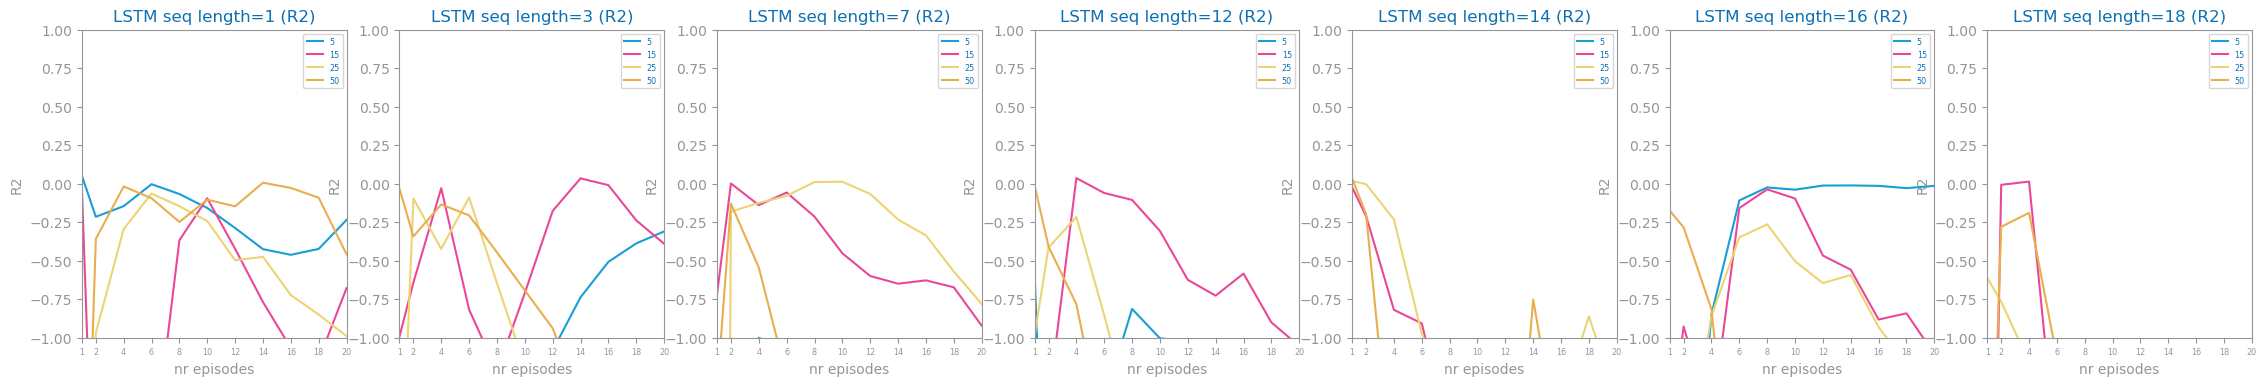

In [24]:
trnY_float = train.pop(target).values.astype(np.float32)
tstY_float = test.pop(target).values.astype(np.float32)
trnX_float = train.values.astype(np.float32)
tstX_float = test.values.astype(np.float32)

# Run the study
best_model, best_params = lstm_study_multi(trnX_float,
                                           trnY_float,
                                           tstX_float,
                                           tstY_float,
                                           nr_episodes=20,
                                           sequence_size=[1,3,7,12,14,16,18],
                                           nr_hidden_units=[5,15,25,50],
                                           measure='R2')

## Pytorch Multivariate Model Evaluation

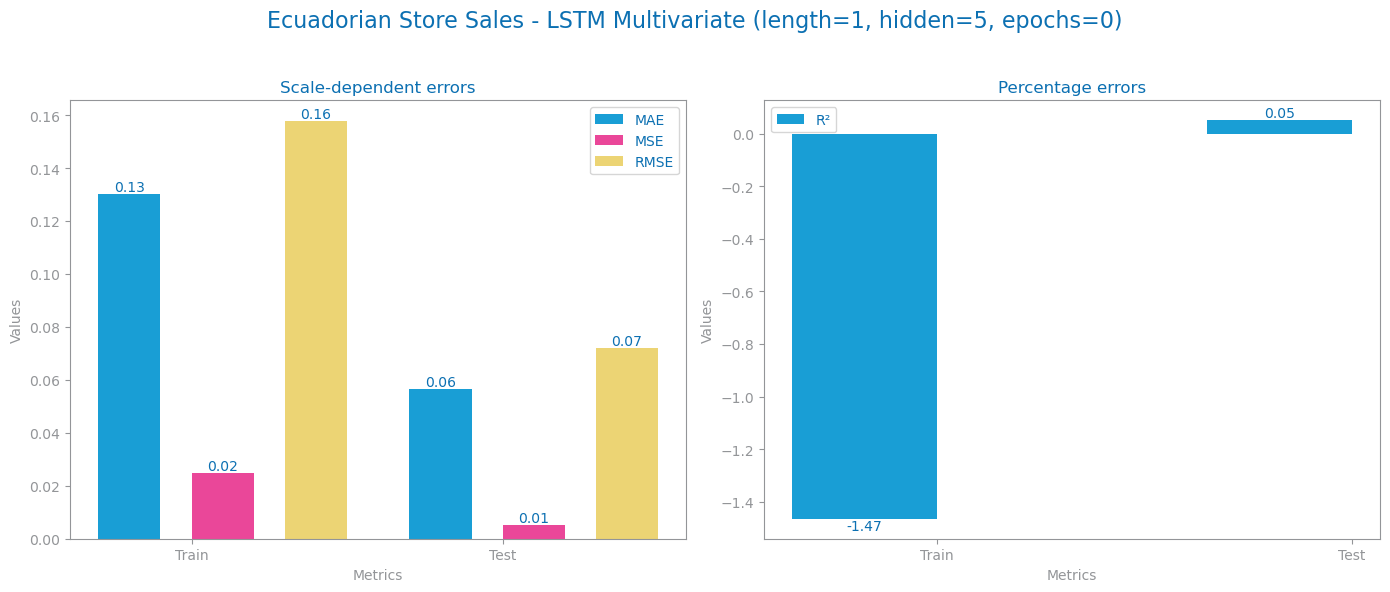

<Figure size 640x480 with 0 Axes>

In [25]:

params = best_params["params"]
best_length = params[0]

train=pd.read_csv(f"dataset/series_scaled_agg_w_train_multi.csv", index_col='date', parse_dates=True,  infer_datetime_format=True)
test=pd.read_csv(f"dataset/series_scaled_agg_w_test_multi.csv", index_col='date', parse_dates=True,  infer_datetime_format=True)

# Assuming `train` and `test` are your DataFrames and `target` is the target column name
trnY_float = train.pop(target).values.astype(np.float32)
tstY_float = test.pop(target).values.astype(np.float32)
trnX_float = train.values.astype(np.float32)
tstX_float = test.values.astype(np.float32)

trnX, trnY = prepare_dataset_for_lstm_multi(trnX_float, trnY_float, seq_length=best_length)
tstX, tstY  = prepare_dataset_for_lstm_multi(tstX_float, tstY_float, seq_length=best_length)

prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

# Assuming train and test are DataFrames with a DateTime index
# Reconstruct the series for plotting
train[target] = trnY_float
test[target] = tstY_float
trn_series = train[[target]]
tst_series = test[[target]]

# Plot the forecasting evaluation
plot_single_model_evaluation(trn_series[best_length:], tst_series[best_length:], prd_trn, prd_tst, title=f"{file_tag} - LSTM Multivariate (length={best_length}, hidden={params[1]}, epochs={params[2]})")
savefig(f"{file_tag}_LSTM_multivariate_predictions.png")

## Pytorch Multivariate Plots

<Axes: xlabel='Date', ylabel='sales'>

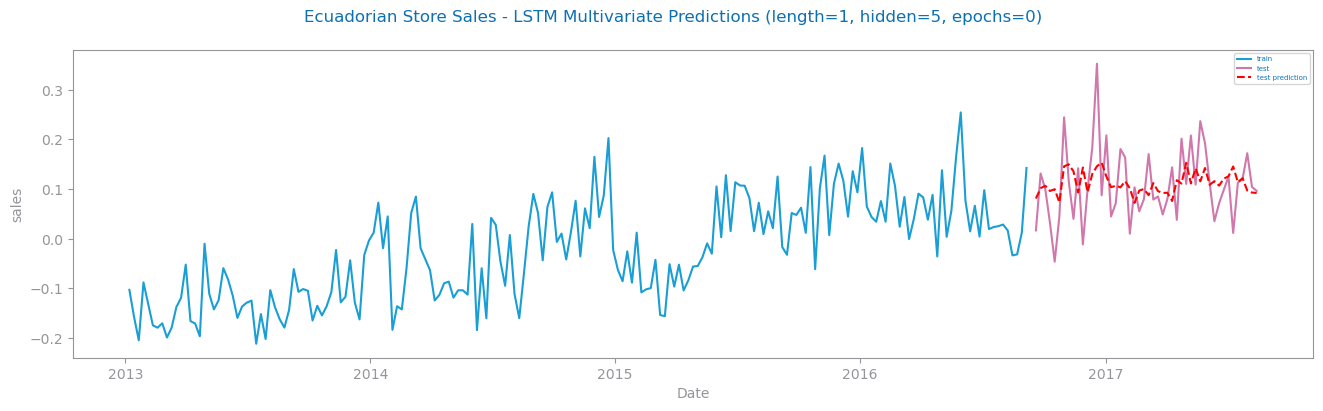

In [26]:
from pandas import Series
pred_series = Series(prd_tst.numpy().ravel(), index=tst_series.index[best_length:])


plot_forecasting_series(
    trn_series[best_length:],
    tst_series[best_length:],
    pred_series,
    title=f"{file_tag} - LSTM Multivariate Predictions (length={best_length}, hidden={params[1]}, epochs={params[2]})",
    xlabel='Date',
    ylabel=target,
)

## Pytorch Multivariate Model and Loss

In [27]:
model = DS_LSTM_Multivariate(trnX_float, trnY_float, input_size=trnX_float.shape[1], hidden_size=50, num_layers=1)
loss = model.fit()
print(loss)

tensor(0.0053, grad_fn=<MseLossBackward0>)
